# Using a Custom Elman RNN for MNIST Classification (row and sequential)

In this notebook, we implement a **custom Elman RNN** to classify the **MNIST dataset** in both **row-wise** and **sequential** formats.

### Overview of the Implementation:
We define two key components:
1. ````CustomRNNLayer```` – A single-layer recurrent neural network (Elman RNN).
2. ````RNNBackbone```` – A full RNN-based model that stacks one or more `CustomRNNLayer` instances and adds a ```final linear layer``` to classify MNIST digits.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import time
from tqdm import tqdm
import lightning as L

import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import sys 
sys.path.append('../Flax')


In [117]:
if torch.cuda.is_available():
    print("CUDA is available")
    print(torch.cuda.get_device_name())
    device = torch.device("cuda")
    print(device)
    print(torch.cuda.current_device())
    print(torch.cuda.device_count())

else:
    print("CUDA is not available")
    device = torch.device("cpu")

# set random seed
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)



CUDA is available
NVIDIA GeForce RTX 4090
cuda
0
1


In [118]:
from utils import create_mnist_classification_dataset

In [119]:
# Hyperparameters
BATCH_SIZE = 128
HIDDEN_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 10
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DATASET_VERSION = "sequential" # "sequential" or "row"

# Create dataset
train_loader, val_loader, test_loader, n_classes, seq_length, in_dim = create_mnist_classification_dataset(
    bsz=BATCH_SIZE, version=DATASET_VERSION
)

# split the dataset into train and validation
train_size = int(0.8 * len(train_loader.dataset))
valid_size = len(train_loader.dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(
    train_loader.dataset, [train_size, valid_size]
)

batch_images, batch_labels = next(iter(train_loader))
print(batch_images.shape)
print(batch_labels.shape)


[*] Generating MNIST Classification Dataset...
(128, 784, 1)
(128,)


In [120]:
# Create model

class LightningRNNBackbone(L.LightningModule):
    def __init__(self, input_size, hidden_size, output_size, criterion, batch_size):
        '''
        RNN backbone using 1 recurrent layer and 1 readout layer
        '''
        super().__init__()
        self.batch_size = batch_size
        self.criterion = criterion
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.input_size = input_size
        self.rnn_layer = nn.RNN(input_size, hidden_size, nonlinearity='tanh', bias=True, batch_first=True)
        
        # Initialize the hidden-to-hidden weights as identity matrix
        for name, param in self.rnn_layer.named_parameters():
            if 'weight_hh' in name:
                print('hello')
                nn.init.normal_(param, mean=0.0, std=torch.sqrt(torch.tensor(1.0/(hidden_size+1))))
                # nn.init.eye_(param)
                # param.data = param.data * 0.9
            if 'bias_hh' in name:
                nn.init.zeros_(param)
            if 'weight_ih' in name:
                # nn.init.ones_(param)
                nn.init.normal_(param, mean=0.0, std=torch.sqrt(torch.tensor(1.0/(hidden_size+1))))
            if 'bias_ih' in name:
                nn.init.zeros_(param)

        self.W_out = nn.Linear(hidden_size, output_size, bias=False)
        self.logger_kwargs = {"batch_size": batch_size, "on_epoch": True, "on_step":True, "prog_bar": True}

    def forward(self, x):
        # x shape: [seq_len, input_size] or [batch_size, seq_len, input_size]
        
        # state_hist, out_hist = self.rnn_layer(x)
        state_hist, _ = self.rnn_layer(x)
        out_hist = self.W_out(state_hist)
        return state_hist, out_hist
    
    def run_batch(self, batch):
        # x shape: [seq_len, input_size] or [batch_size, seq_len, input_size]
        x, y = batch
        x = torch.tensor(x, dtype=torch.float32).to(self.device)
        y = torch.tensor(y, dtype=torch.long).to(self.device)
        # state_hist, out_hist = self.rnn_layer(x)
        state_hist, _ = self(x)
        out_hist = self.W_out(state_hist)
        final_outputs = out_hist.mean(dim=1)
        return self.criterion(final_outputs, y)

    
    def training_step(self, batch, batch_idx):

        loss = self.run_batch(batch)
        # Logging to TensorBoard (if installed) by default
        # self.log("train_loss", loss, prog_bar=True, on_epoch=True, batch_size=128)
        self.log("train_loss", loss, **self.logger_kwargs) 

        return loss
    
    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        loss = self.run_batch(batch)
        self.log("val_loss", loss, **self.logger_kwargs) 
        return loss
    
    def test_step(self, batch, batch_idx):
        # this is the test loop
        loss = self.run_batch(batch)
        self.log("test_loss", loss, **self.logger_kwargs) 
        return loss

    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


In [121]:
model = LightningRNNBackbone(in_dim, HIDDEN_SIZE, n_classes, nn.CrossEntropyLoss(), BATCH_SIZE)
model.to(device)
print(model.device)
print(model.rnn_layer.weight_hh_l0)


hello
cuda:0
Parameter containing:
tensor([[-0.0565,  0.0356, -0.0545,  ..., -0.1168,  0.0329, -0.2150],
        [ 0.0005,  0.1554,  0.0080,  ...,  0.1018,  0.1406,  0.1272],
        [ 0.0593,  0.0235,  0.1892,  ...,  0.0899,  0.0839,  0.0756],
        ...,
        [ 0.0540, -0.1663, -0.1019,  ..., -0.0739, -0.0741,  0.0330],
        [-0.0493, -0.1755,  0.0698,  ..., -0.0501, -0.0847, -0.2196],
        [ 0.1280,  0.0230, -0.1281,  ...,  0.0844,  0.1230, -0.2316]],
       device='cuda:0', requires_grad=True)


In [122]:
# from lightning.pytorch.callbacks import RichProgressBar

# # train the model (hint: here are some helpful Trainer arguments for rapid idea iteration)
# callbacks = [RichProgressBar(leave=True)]
from lightning.pytorch.loggers import TensorBoardLogger
logger = TensorBoardLogger("logs/", name="rnn_experiment")

from lightning.pytorch.callbacks import TQDMProgressBar
callbacks = [TQDMProgressBar(leave=True)]
trainer = L.Trainer(max_epochs=2, callbacks=callbacks,
                    log_every_n_steps=50,
                    limit_train_batches=200, 
                    enable_progress_bar=True, logger=logger)
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)


In [123]:
# test the model
trainer.test(model, dataloaders=test_loader)


In [124]:
batch_images, batch_labels = next(iter(test_loader))
batch_images = torch.tensor(batch_images, dtype=torch.float32).to(device)
batch_labels = torch.tensor(batch_labels, dtype=torch.long).to(device)

print(batch_images.device)
print(batch_labels.device)
print(model.device)
model.to(device)
model.eval()
with torch.no_grad():
    state_hist, out_hist = model(batch_images)
    final_outputs = out_hist.mean(dim=1)
    preds = final_outputs.argmax(dim=1)
    accuracy = (preds == batch_labels).float().mean()
    print(f"Accuracy: {accuracy.item() * 100:.2f}%")
    print(f"Predictions: {preds}")
    print(f"Ground Truth: {batch_labels}")
    print(f"Loss: {F.cross_entropy(final_outputs, batch_labels)}")
    

cuda:0
cuda:0
cuda:0
Accuracy: 7.81%
Predictions: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Ground Truth: tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0,
        2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4,
        1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7, 3, 9, 7, 4, 4, 4, 9, 2,
        5, 4, 7, 6, 7, 9, 0, 5], device='cuda:0')
Loss: 2.304011106491089


In [125]:
print(state_hist.shape)

torch.Size([128, 784, 64])


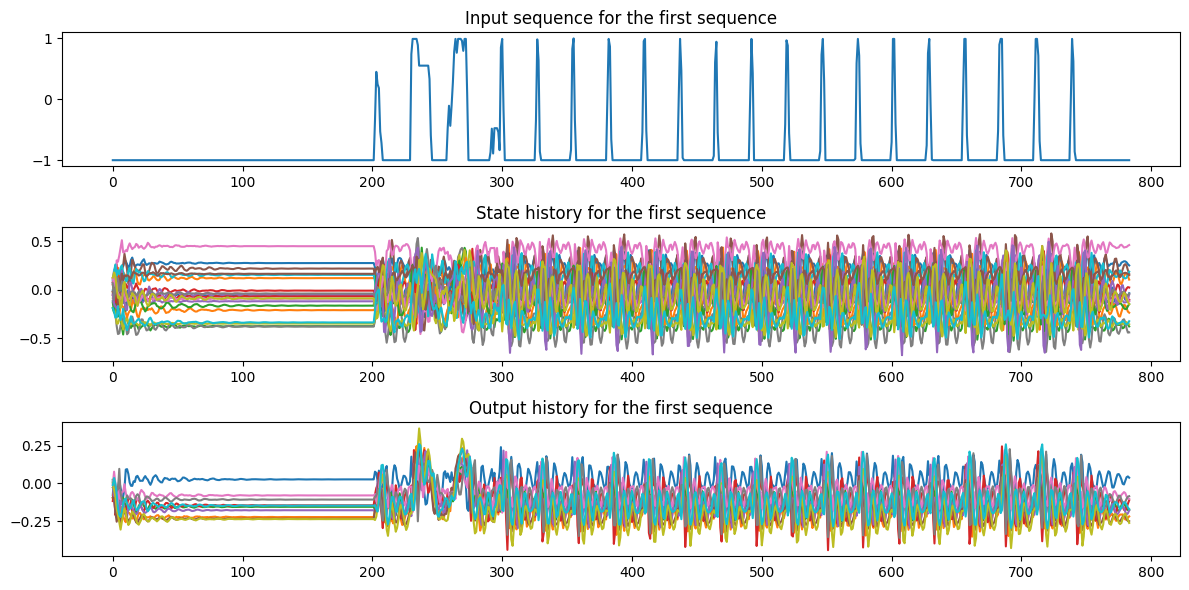

In [126]:
import matplotlib.pyplot as plt
px = 1 / plt.rcParams['figure.dpi']  # pixel in inches

fig, axs = plt.subplots(3, 1, figsize=(1200*px, 600*px))
axs[0].plot(batch_images[0].cpu().numpy())
axs[0].set_title("Input sequence for the first sequence")
axs[1].plot(state_hist[0, :, :20].cpu().numpy())
axs[1].set_title("State history for the first sequence")
axs[-1].plot(out_hist[0, :, :].cpu().numpy())
axs[-1].set_title("Output history for the first sequence")
# axs[1].set_yticks(np.arange(0,1.1, 0.1))
# axs[1].grid()
plt.tight_layout()
plt.show()

In [85]:
print(model.rnn_layer.weight_hh_l0)

Parameter containing:
tensor([[ 0.8262, -0.1199, -0.0736,  ..., -0.4295,  0.3076,  0.1816],
        [-0.3038,  0.7654, -0.4285,  ...,  0.2372,  0.1393,  1.0680],
        [-0.0247, -1.0878,  0.5510,  ...,  0.1155, -0.2085, -0.4758],
        ...,
        [-0.5415,  0.5343, -0.5502,  ..., -0.2837,  0.7389, -0.2011],
        [ 0.3765, -0.1976,  0.5915,  ..., -0.4454,  0.2767,  1.0966],
        [-0.1000,  0.5160, -0.0992,  ...,  0.0656,  1.0806, -0.5690]],
       device='cuda:0', requires_grad=True)


In [66]:
print(model.rnn_layer.weight_ih_l0)

Parameter containing:
tensor([[-0.1180],
        [ 0.0935],
        [ 0.0650],
        [ 0.0088],
        [-0.0335],
        [-0.0455],
        [ 0.0266],
        [-0.0726],
        [ 0.0055],
        [-0.0540],
        [ 0.0780],
        [-0.0986],
        [ 0.0575],
        [-0.0773],
        [ 0.0375],
        [ 0.0276],
        [ 0.1207],
        [ 0.0594],
        [-0.0113],
        [-0.0713],
        [ 0.0121],
        [-0.1077],
        [-0.0164],
        [ 0.0817],
        [-0.0627],
        [-0.0700],
        [-0.1190],
        [-0.0832],
        [-0.0130],
        [ 0.0412],
        [-0.0960],
        [-0.1203],
        [-0.0011],
        [ 0.0669],
        [ 0.0355],
        [-0.0381],
        [ 0.0785],
        [ 0.0327],
        [ 0.0364],
        [-0.1152],
        [-0.0720],
        [ 0.1235],
        [-0.1212],
        [ 0.0855],
        [ 0.0976],
        [-0.1080],
        [-0.0660],
        [ 0.0307],
        [-0.0469],
        [-0.0060],
        [ 0.0432],
        [

In [67]:
print(model.rnn_layer.bias_hh_l0)
print(model.rnn_layer.bias_ih_l0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', requires_grad=True)
